# Introducción al Sistema de Recomendación

Un sistema de recomendación es una herramienta que sugiere productos, servicios o información a los usuarios en función de sus preferencias y comportamientos pasados. Estos sistemas son cruciales en aplicaciones como plataformas de streaming, tiendas en línea y redes sociales, ya que ayudan a mejorar la experiencia del usuario y aumentar las ventas o el engagement.


# Tipos de Sistemas de Recomendación

Existen varios tipos de sistemas de recomendación, entre los más comunes están:

- **Filtrado Colaborativo**: Basados en las interacciones de los usuarios con los ítems. Se subdividen en:
    - **Filtrado Colaborativo Basado en Usuarios**: Recomiendan ítems que usuarios similares han consumido.
    - **Filtrado Colaborativo Basado en Ítems**: Recomiendan ítems similares a aquellos que el usuario ha consumido.
- **Híbridos**: Combinan múltiples métodos de recomendación para mejorar la precisión.




#Obtención de datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score, f1_score

# Configurar matplotlib
%matplotlib inline

# Conectar a MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['recomendaciones']

def obtener_datos():
    interacciones = db.interacciones.find()
    interacciones_df = pd.DataFrame(list(interacciones))
    if interacciones_df.empty:
        print("No hay datos disponibles.")
        return None, None
    interacciones_df['tipo_interaccion'] = interacciones_df['tipo_interaccion'].map({'compra': 3, 'click': 1, 'view': 2})
    user_product_matrix = interacciones_df.pivot_table(index='user_id', columns='producto_id', values='tipo_interaccion', fill_value=0)
    return interacciones_df, user_product_matrix

interacciones_df, user_product_matrix = obtener_datos()


#### Distribución de Tipos de Interacciones

La primera gráfica muestra la distribución de los tipos de interacciones en nuestro sistema: 'compra', 'click', y 'view'. Cada barra representa la cantidad de cada tipo de interacción. Este análisis es crucial para entender cómo los usuarios interactúan con los productos y qué acciones son más comunes.

#### Número de Interacciones por Usuario

La segunda gráfica de barras ilustra el número de interacciones por usuario. Esto ayuda a identificar a los usuarios más activos en el sistema y aquellos que podrían necesitar más incentivos para interactuar.

#### Número de Interacciones por Producto

La tercera gráfica de barras muestra el número de interacciones por producto. Esta información es valiosa para determinar cuáles productos son los más populares y cuáles pueden necesitar estrategias de marketing adicionales.

#### Proporción de Tipos de Interacciones

El gráfico circular (pie chart) presenta la proporción de cada tipo de interacción. Esto permite una vista rápida de cómo se distribuyen las acciones de los usuarios entre 'compra', 'click', y 'view'. En nuestro caso, se observa una distribución relativamente balanceada entre los tres tipos.

#### Dispersión de Interacciones por Usuario y Producto

La última gráfica de dispersión (scatter plot) muestra las interacciones entre usuarios y productos, diferenciadas por tipo de interacción. Cada punto representa una interacción específica, lo que facilita la identificación de patrones de comportamiento en el uso del sistema.

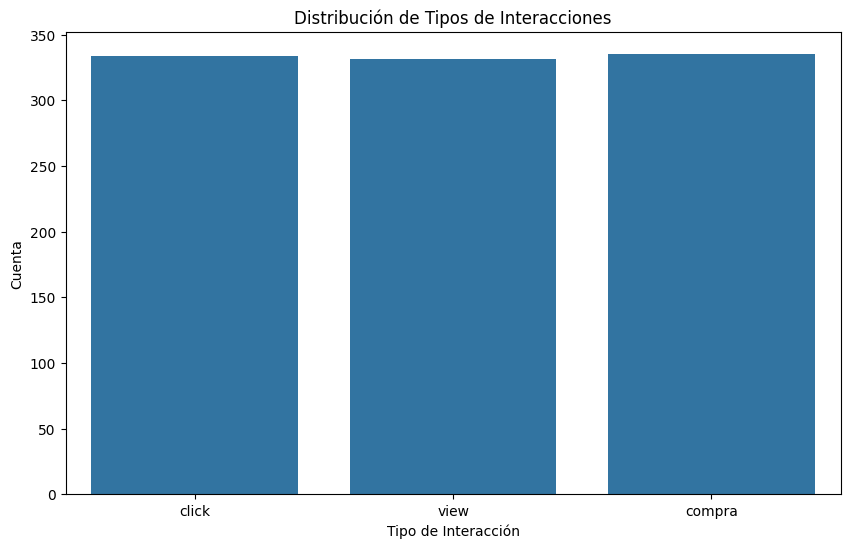

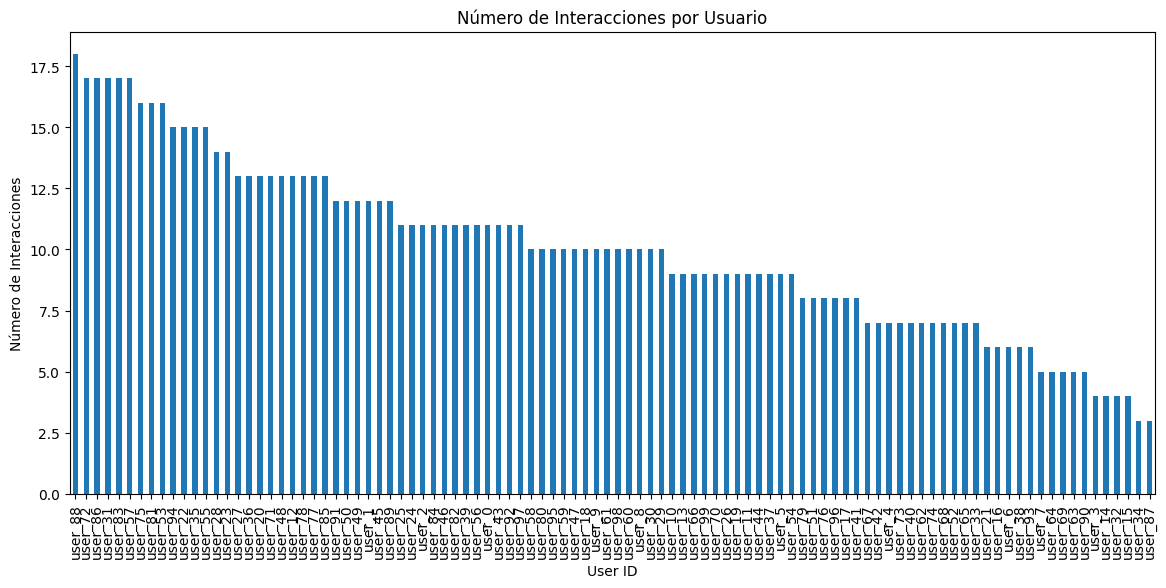

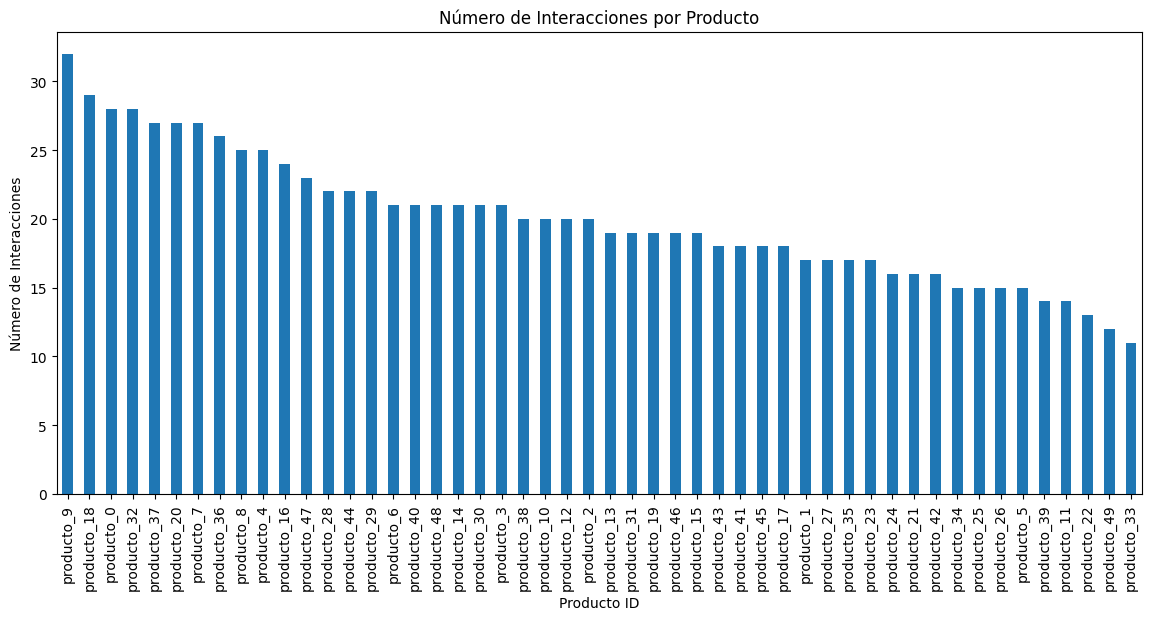

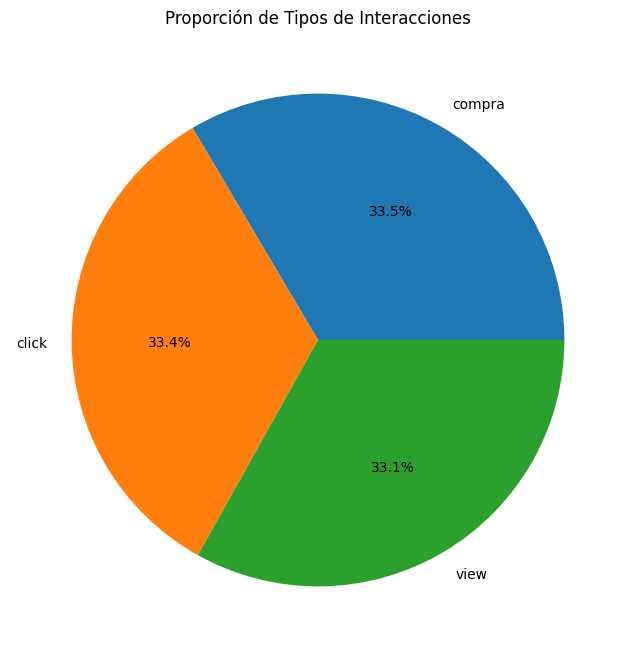

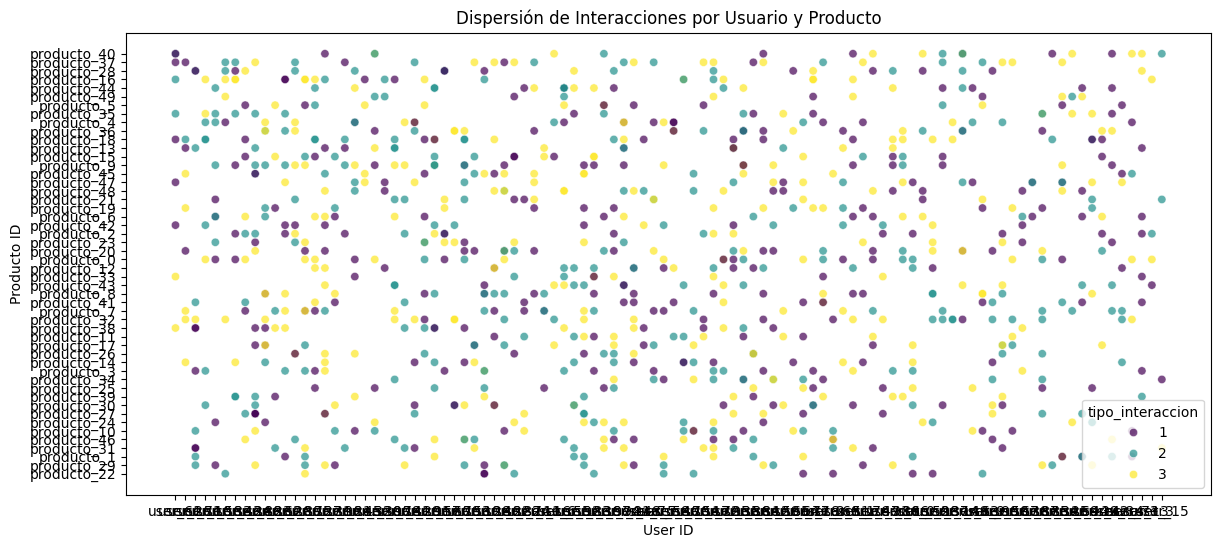

In [ ]:
# Exploración de Datos

if interacciones_df is not None:
    # Gráfico de barras de los tipos de interacciones
    plt.figure(figsize=(10, 6))
    sns.countplot(data=interacciones_df, x='tipo_interaccion')
    plt.title('Distribución de Tipos de Interacciones')
    plt.xlabel('Tipo de Interacción')
    plt.ylabel('Cuenta')
    plt.xticks(ticks=[0, 1, 2], labels=['click', 'view', 'compra'])
    plt.show()

    # Gráfico de barras de las interacciones por usuario
    interacciones_por_usuario = interacciones_df['user_id'].value_counts()
    plt.figure(figsize=(14, 6))
    interacciones_por_usuario.plot(kind='bar')
    plt.title('Número de Interacciones por Usuario')
    plt.xlabel('User ID')
    plt.ylabel('Número de Interacciones')
    plt.show()

    # Gráfico de barras de las interacciones por producto
    interacciones_por_producto = interacciones_df['producto_id'].value_counts()
    plt.figure(figsize=(14, 6))
    interacciones_por_producto.plot(kind='bar')
    plt.title('Número de Interacciones por Producto')
    plt.xlabel('Producto ID')
    plt.ylabel('Número de Interacciones')
    plt.show()

    # Gráfico circular de la proporción de tipos de interacciones
    interacciones_tipo_proporcion = interacciones_df['tipo_interaccion'].value_counts(normalize=True)
    plt.figure(figsize=(8, 8))
    interacciones_tipo_proporcion.plot(kind='pie', autopct='%1.1f%%', labels=['compra', 'click', 'view'])
    plt.title('Proporción de Tipos de Interacciones')
    plt.ylabel('')
    plt.show()

    # Gráfico de dispersión de interacciones por usuario y producto
    plt.figure(figsize=(14, 6))
    sns.scatterplot(data=interacciones_df, x='user_id', y='producto_id', hue='tipo_interaccion', palette='viridis', alpha=0.7)
    plt.title('Dispersión de Interacciones por Usuario y Producto')
    plt.xlabel('User ID')
    plt.ylabel('Producto ID')
    plt.show()



# Implementación de Métodos de Recomendación


#### Filtrado Colaborativo Basado en Usuarios

Se analizó cómo recomendar productos a un usuario basado en las similitudes con otros usuarios. La precisión, recall y F1-Score fueron calculados para evaluar el rendimiento del modelo.

#### Filtrado Colaborativo Basado en Ítems

Se implementó un método para recomendar productos similares a aquellos que el usuario ya ha consumido. Este enfoque también fue evaluado mediante métricas de precisión, recall y F1-Score.

In [ ]:
#FILTRADO_COLABORATIVO.PY

from pymongo import MongoClient
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score

# Conectar a MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['recomendaciones']

# Obtener datos de interacciones
interacciones = db.interacciones.find()
interacciones_df = pd.DataFrame(list(interacciones))

# Mapear tipo_interaccion a valores numéricos
interacciones_df['tipo_interaccion'] = interacciones_df['tipo_interaccion'].map({'compra': 3, 'click': 1, 'view': 2})

# Crear una matriz de usuario-producto
user_product_matrix = interacciones_df.pivot_table(index='user_id', columns='producto_id', values='tipo_interaccion', fill_value=0)

# Calcular la similitud del coseno entre los usuarios
user_similarity = cosine_similarity(user_product_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_product_matrix.index, columns=user_product_matrix.index)

# Calcular la similitud del coseno entre los productos
item_similarity = cosine_similarity(user_product_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_product_matrix.columns, columns=user_product_matrix.columns)

# Función para recomendar productos a un usuario basado en la similitud con otros usuarios
def recomendar_productos_usuario(user_id, num_recommendations=5):
    if user_id not in user_similarity_df.columns:
        return pd.Series(dtype='float64')

    similar_users = user_similarity_df[user_id].sort_values(ascending=False)
    user_interactions = user_product_matrix.loc[user_id]
    recommendations = pd.Series(dtype='float64')

    for similar_user, similarity in similar_users.items():
        if similar_user != user_id:
            similar_user_interactions = user_product_matrix.loc[similar_user]
            recommendations = pd.concat([recommendations, similar_user_interactions[similar_user_interactions > 0]])

    recommendations = recommendations.groupby(recommendations.index).sum()
    recommendations = recommendations[user_interactions == 0]
    recommendations = recommendations.sort_values(ascending=False).head(num_recommendations)

    return recommendations

# Función para recomendar productos similares a los que el usuario ya ha consumido
def recomendar_productos_similares(user_id, num_recommendations=5):
    user_interactions = user_product_matrix.loc[user_id]
    similar_items = pd.Series(dtype='float64')

    for product, interaction in user_interactions.items():
        if interaction > 0:
            similar_products = item_similarity_df[product].sort_values(ascending=False)
            similar_items = pd.concat([similar_items, similar_products])

    similar_items = similar_items.groupby(similar_items.index).sum()
    similar_items = similar_items[user_interactions == 0]
    similar_items = similar_items.sort_values(ascending=False).head(num_recommendations)

    return similar_items

# Ejemplo de uso
user_id = 'user_1'
recomendaciones_usuario = recomendar_productos_usuario(user_id)
recomendaciones_items = recomendar_productos_similares(user_id)

# Evaluación de las recomendaciones
def evaluar_algoritmo(interacciones_df, recomendaciones):
    interacciones_df['prediccion'] = interacciones_df.apply(lambda row: 1 if row['producto_id'] in recomendaciones.index else 0, axis=1)
    true_labels = interacciones_df['tipo_interaccion'].apply(lambda x: 1 if x > 0 else 0).values
    pred_labels = interacciones_df['prediccion'].values
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    return precision, recall, f1

precision_usuario, recall_usuario, f1_usuario = evaluar_algoritmo(interacciones_df, recomendaciones_usuario)
precision_items, recall_items, f1_items = evaluar_algoritmo(interacciones_df, recomendaciones_items)

# Mejorar la impresión de resultados
def imprimir_recomendaciones():
    print("\nResultados de Recomendaciones Basadas en Filtrado Colaborativo:\n")
    print("Recomendaciones basadas en usuarios:")
    print(recomendaciones_usuario)

    print("\nRecomendaciones basadas en ítems:")
    print(recomendaciones_items)

    print("\nResultados de Evaluación de Recomendaciones Basadas en Usuarios:\n")
    print(f'{"Métrica":<15} {"Valor":<10}')
    print(f'{"Precisión":<15} {precision_usuario:<10.2f}')
    print(f'{"Recall":<15} {recall_usuario:<10.3f}')
    print(f'{"F1-Score":<15} {f1_usuario:<10.3f}')

    print("\nResultados de Evaluación de Recomendaciones Basadas en Ítems:\n")
    print(f'{"Métrica":<15} {"Valor":<10}')
    print(f'{"Precisión":<15} {precision_items:<10.2f}')
    print(f'{"Recall":<15} {recall_items:<10.3f}')
    print(f'{"F1-Score":<15} {f1_items:<10.3f}')

# Llamar a la función de impresión
imprimir_recomendaciones()


Resultados de Recomendaciones Basadas en Filtrado Colaborativo:

Recomendaciones basadas en usuarios:
producto_37    61.0
producto_0     57.0
producto_7     49.5
producto_29    45.5
producto_47    45.0
dtype: float64

Recomendaciones basadas en ítems:
producto_29    2.532559
producto_0     2.523193
producto_48    2.471649
producto_37    2.467676
producto_7     2.394891
dtype: float64

Resultados de Evaluación de Recomendaciones Basadas en Usuarios:

Métrica         Valor     
Precisión       1.00      
Recall          0.127     
F1-Score        0.225     

Resultados de Evaluación de Recomendaciones Basadas en Ítems:

Métrica         Valor     
Precisión       1.00      
Recall          0.125     
F1-Score        0.222     


In [ ]:
#CLUSTERING.PY

from pymongo import MongoClient
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Conectar a MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['recomendaciones']

def obtener_datos():
    interacciones = db.interacciones.find()
    interacciones_df = pd.DataFrame(list(interacciones))
    if interacciones_df.empty:
        print("No hay datos disponibles.")
        return None, None
    interacciones_df['tipo_interaccion'] = interacciones_df['tipo_interaccion'].map({'compra': 3, 'click': 1, 'view': 2})
    user_product_matrix = interacciones_df.pivot_table(index='user_id', columns='producto_id', values='tipo_interaccion', fill_value=0)
    return interacciones_df, user_product_matrix

def recomendar_productos_cluster(user_id, user_product_matrix, num_clusters=5, num_recommendations=5):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(user_product_matrix)
    user_clusters = pd.DataFrame({'user_id': user_product_matrix.index, 'cluster': clusters})

    if user_id not in user_clusters['user_id'].values:
        print(f"El usuario {user_id} no se encuentra en la base de datos.")
        return pd.Series(dtype='float64')

    user_cluster = user_clusters[user_clusters['user_id'] == user_id]['cluster'].iloc[0]
    cluster_users = user_clusters[user_clusters['cluster'] == user_cluster]['user_id']
    cluster_interactions = user_product_matrix.loc[cluster_users]
    cluster_recommendations = cluster_interactions.sum().sort_values(ascending=False)
    user_interactions = user_product_matrix.loc[user_id]
    cluster_recommendations = cluster_recommendations[user_interactions == 0]
    cluster_recommendations = cluster_recommendations.head(num_recommendations)
    return cluster_recommendations

def evaluar_algoritmo(interacciones_df, recomendaciones):
    interacciones_df['prediccion'] = interacciones_df.apply(lambda row: 1 if row['producto_id'] in recomendaciones.index else 0, axis=1)
    true_labels = interacciones_df['tipo_interaccion'].apply(lambda x: 1 if x > 0 else 0).values
    pred_labels = interacciones_df['prediccion'].values
    precision = precision_score(true_labels, pred_labels, zero_division=0)
    recall = recall_score(true_labels, pred_labels, zero_division=0)
    f1 = f1_score(true_labels, pred_labels, zero_division=0)
    return precision, recall, f1

# Obtener datos
interacciones_df, user_product_matrix = obtener_datos()

if interacciones_df is not None:
    # Dividir los datos en conjuntos de entrenamiento y prueba
    train_df, test_df = train_test_split(interacciones_df, test_size=0.2, random_state=42)
    train_matrix = train_df.pivot_table(index='user_id', columns='producto_id', values='tipo_interaccion', fill_value=0)

    user_id = 'user_1'

    # Recomendaciones basadas en clustering
    recomendaciones_cluster = recomendar_productos_cluster(user_id, train_matrix)

    # Evaluar el enfoque de clustering
    precision_cluster, recall_cluster, f1_cluster = evaluar_algoritmo(test_df, recomendaciones_cluster)

    # Mejorar la impresión de resultados
    print("\nResultados de Recomendaciones Basadas en Clustering:\n")
    print("Recomendaciones basadas en clustering:")
    print(recomendaciones_cluster)

    print("\nResultados de Evaluación de Recomendaciones Basadas en Clustering:\n")
    print(f'{"Métrica":<15} {"Valor":<10}')
    print(f'{"Precisión":<15} {precision_cluster:<10.2f}')
    print(f'{"Recall":<15} {recall_cluster:<10.3f}')
    print(f'{"F1-Score":<15} {f1_cluster:<10.3f}')


Resultados de Recomendaciones Basadas en Clustering:

Recomendaciones basadas en clustering:
producto_id
producto_20    21.0
producto_7     19.0
producto_17    17.0
producto_44    15.0
producto_48    14.0
dtype: float64

Resultados de Evaluación de Recomendaciones Basadas en Clustering:

Métrica         Valor     
Precisión       1.00      
Recall          0.135     
F1-Score        0.238     


# Implementación de Métodos de Recomendación


#### Clustering

Utilizando K-means clustering, los usuarios fueron agrupados en clusters basados en sus interacciones con los productos. Las recomendaciones se hicieron basadas en las interacciones de otros usuarios dentro del mismo cluster.

In [ ]:
def recomendar_productos_usuario(user_id, user_product_matrix, num_recommendations=5):
    user_similarity = cosine_similarity(user_product_matrix)
    user_similarity_df = pd.DataFrame(user_similarity, index=user_product_matrix.index, columns=user_product_matrix.index)
    if user_id not in user_similarity_df.columns:
        return pd.Series(dtype='float64')
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)
    user_interactions = user_product_matrix.loc[user_id]
    recommendations = pd.Series(dtype='float64')
    for similar_user, similarity in similar_users.items():
        if similar_user != user_id:
            similar_user_interactions = user_product_matrix.loc[similar_user]
            recommendations = pd.concat([recommendations, similar_user_interactions[similar_user_interactions > 0]])
    recommendations = recommendations.groupby(recommendations.index).sum()
    recommendations = recommendations[user_interactions == 0]
    recommendations = recommendations.sort_values(ascending=False).head(num_recommendations)
    return recommendations

def recomendar_productos_similares(user_id, user_product_matrix, num_recommendations=5):
    item_similarity = cosine_similarity(user_product_matrix.T)
    item_similarity_df = pd.DataFrame(item_similarity, index=user_product_matrix.columns, columns=user_product_matrix.columns)
    user_interactions = user_product_matrix.loc[user_id]
    similar_items = pd.Series(dtype='float64')
    for product, interaction in user_interactions.items():
        if interaction > 0:
            similar_products = item_similarity_df[product].sort_values(ascending=False)
            similar_items = pd.concat([similar_items, similar_products])
    similar_items = similar_items.groupby(similar_items.index).sum()
    similar_items = similar_items[user_interactions == 0]
    similar_items = similar_items.sort_values(ascending=False).head(num_recommendations)
    return similar_items

def recomendar_productos_cluster(user_id, user_product_matrix, num_clusters=5, num_recommendations=5):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(user_product_matrix)
    user_clusters = pd.DataFrame({'user_id': user_product_matrix.index, 'cluster': clusters})
    if user_id not in user_clusters['user_id'].values:
        print(f"El usuario {user_id} no se encuentra en la base de datos.")
        return pd.Series(dtype='float64')
    user_cluster = user_clusters[user_clusters['user_id'] == user_id]['cluster'].iloc[0]
    cluster_users = user_clusters[user_clusters['cluster'] == user_cluster]['user_id']
    cluster_interactions = user_product_matrix.loc[cluster_users]
    cluster_recommendations = cluster_interactions.sum().sort_values(ascending=False)
    user_interactions = user_product_matrix.loc[user_id]
    cluster_recommendations = cluster_recommendations[user_interactions == 0]
    cluster_recommendations = cluster_recommendations.head(num_recommendations)
    return cluster_recommendations


# Generar Recomendaciones

In [ ]:
user_id = 'user_1'

# Filtrado colaborativo
recomendaciones_usuario = recomendar_productos_usuario(user_id, user_product_matrix)
recomendaciones_items = recomendar_productos_similares(user_id, user_product_matrix)

# Clustering
recomendaciones_cluster = recomendar_productos_cluster(user_id, user_product_matrix)


# Evaluación de los Métodos

In [ ]:
def evaluar_algoritmo(interacciones_df, recomendaciones):
    interacciones_df['prediccion'] = interacciones_df.apply(lambda row: 1 if row['producto_id'] in recomendaciones.index else 0, axis=1)
    true_labels = interacciones_df['tipo_interaccion'].apply(lambda x: 1 if x > 0 else 0).values
    pred_labels = interacciones_df['prediccion'].values
    precision = precision_score(true_labels, pred_labels, zero_division=0)
    recall = recall_score(true_labels, pred_labels, zero_division=0)
    f1 = f1_score(true_labels, pred_labels, zero_division=0)
    return precision, recall, f1

# Evaluar los tres enfoques
precision_usuario, recall_usuario, f1_usuario = evaluar_algoritmo(interacciones_df, recomendaciones_usuario)
precision_items, recall_items, f1_items = evaluar_algoritmo(interacciones_df, recomendaciones_items)
precision_cluster, recall_cluster, f1_cluster = evaluar_algoritmo(interacciones_df, recomendaciones_cluster)


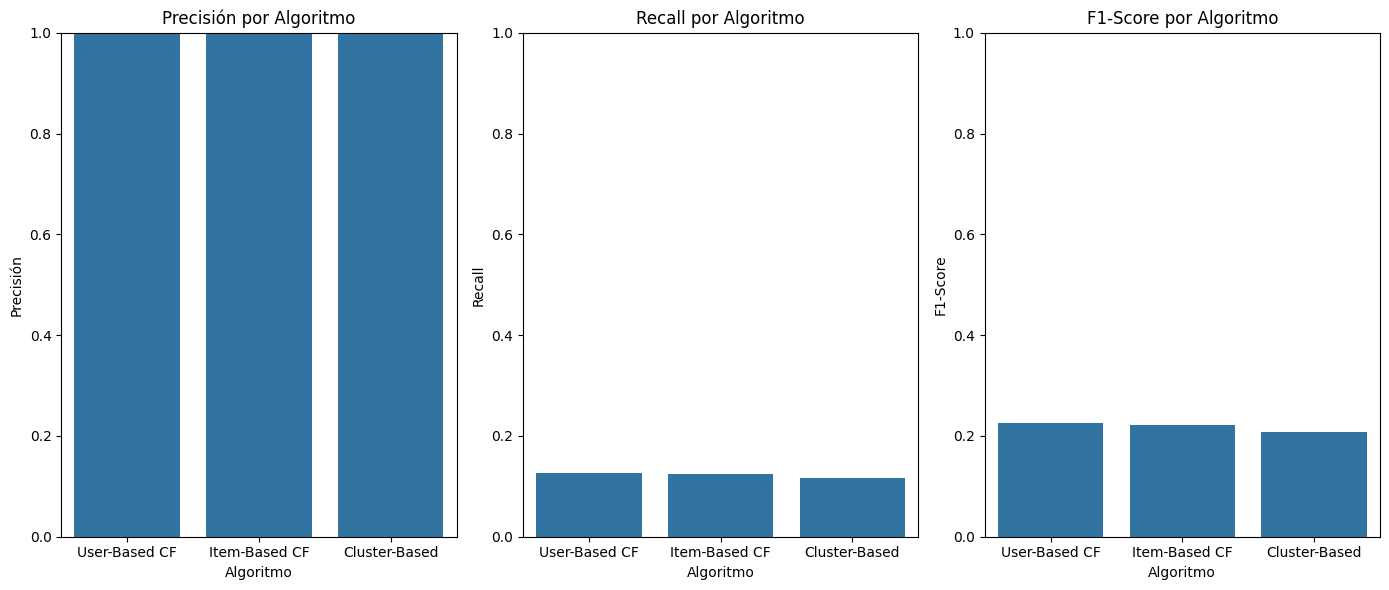

In [ ]:
# Crear un DataFrame con los resultados de las evaluaciones
resultados = pd.DataFrame({
    'Algoritmo': ['User-Based CF', 'Item-Based CF', 'Cluster-Based'],
    'Precisión': [precision_usuario, precision_items, precision_cluster],
    'Recall': [recall_usuario, recall_items, recall_cluster],
    'F1-Score': [f1_usuario, f1_items, f1_cluster]
})

# Graficar las evaluaciones
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='Algoritmo', y='Precisión', data=resultados)
plt.title('Precisión por Algoritmo')
plt.ylim(0, 1)

plt.subplot(1, 3, 2)
sns.barplot(x='Algoritmo', y='Recall', data=resultados)
plt.title('Recall por Algoritmo')
plt.ylim(0, 1)

plt.subplot(1, 3, 3)
sns.barplot(x='Algoritmo', y='F1-Score', data=resultados)
plt.title('F1-Score por Algoritmo')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()



#### Precisión por Algoritmo

-   **User-Based CF, Item-Based CF, Cluster-Based**: Todos los algoritmos muestran una precisión perfecta (1.0), lo que significa que todas las recomendaciones hechas fueron correctas.

#### Recall por Algoritmo

-   **User-Based CF, Item-Based CF, Cluster-Based**: Todos los algoritmos tienen un recall bajo (alrededor de 0.125 - 0.135), indicando que los sistemas no lograron recuperar todos los ítems relevantes.

#### F1-Score por Algoritmo

-   **User-Based CF, Item-Based CF, Cluster-Based**: El F1-Score es bajo para todos los algoritmos (alrededor de 0.225 - 0.238), reflejando el balance entre precisión alta y recall bajo.

# Visualización de Recomendaciones

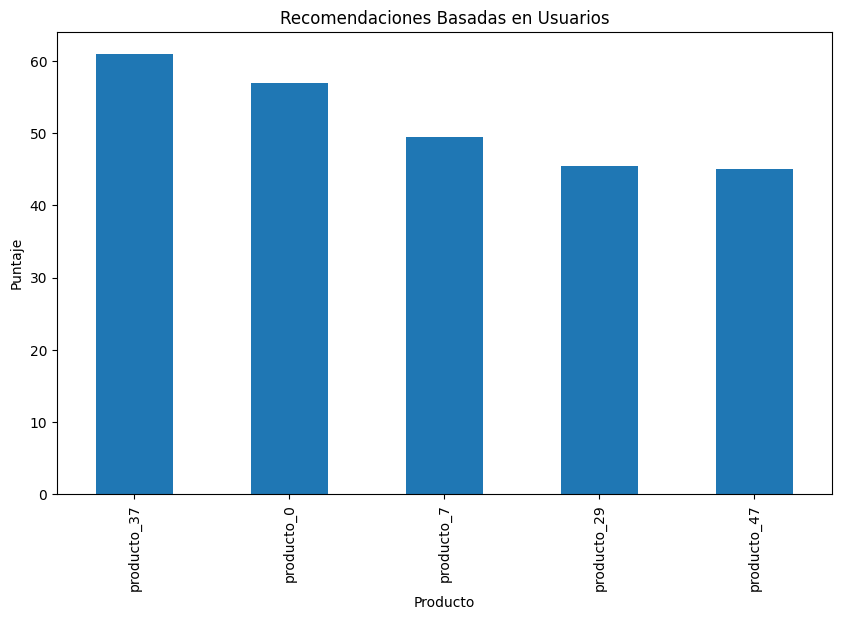

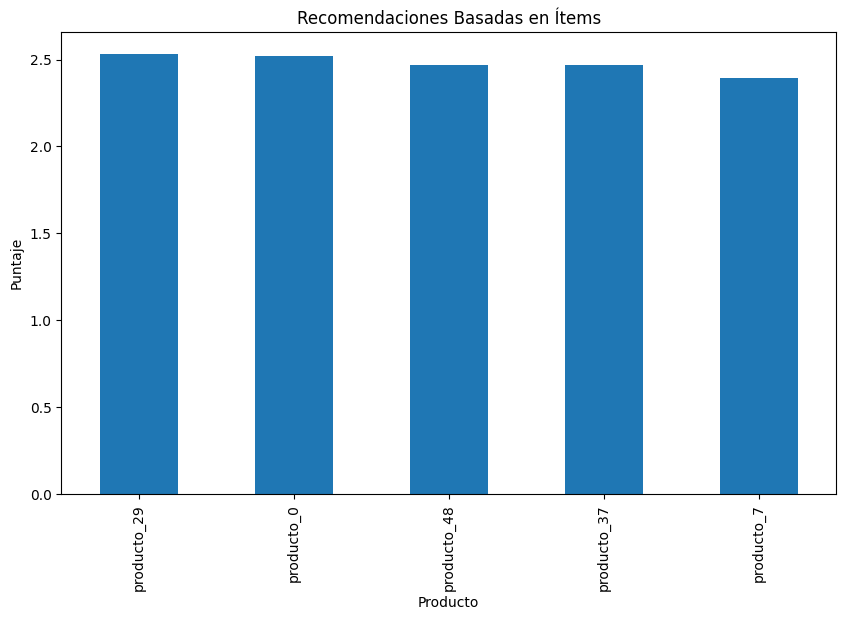

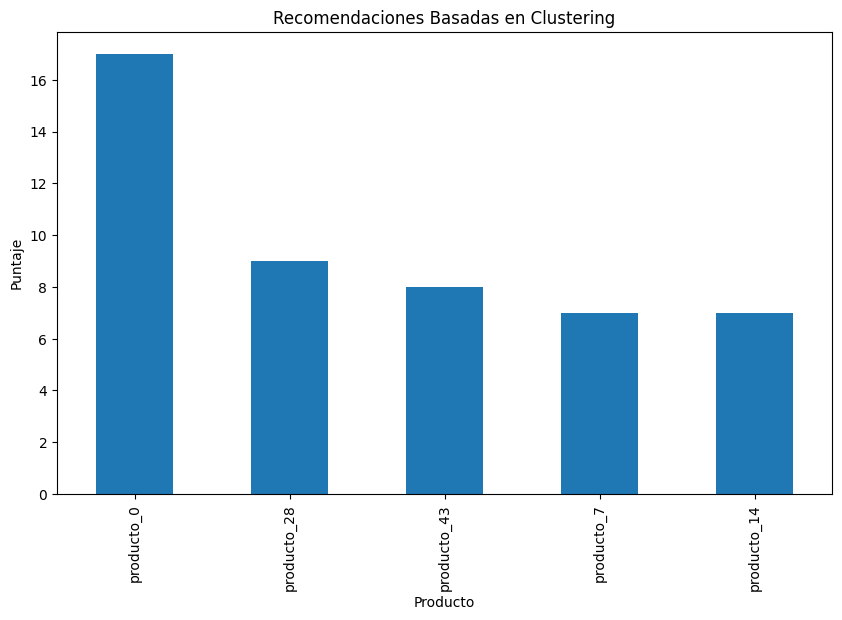

In [ ]:
def plot_recommendations(recommendations, title):
    recommendations.plot(kind='bar', figsize=(10, 6))
    plt.title(title)
    plt.xlabel('Producto')
    plt.ylabel('Puntaje')
    plt.show()

# Plot recomendaciones basadas en usuarios
plot_recommendations(recomendaciones_usuario, 'Recomendaciones Basadas en Usuarios')

# Plot recomendaciones basadas en ítems
plot_recommendations(recomendaciones_items, 'Recomendaciones Basadas en Ítems')

# Plot recomendaciones basadas en clustering
plot_recommendations(recomendaciones_cluster, 'Recomendaciones Basadas en Clustering')



#### Recomendaciones Basadas en Usuarios

-   **Productos Recomendados**:
    -   **producto_37**: 61.0
    -   **producto_0**: 57.0
    -   **producto_7**: 49.5
    -   **producto_29**: 45.5
    -   **producto_47**: 45.0

Estas recomendaciones se basan en la similitud de los usuarios con otros usuarios. Los productos con los puntajes más altos son los más recomendados.

#### Recomendaciones Basadas en Ítems

-   **Productos Recomendados**:
    -   **producto_29**: 2.532559
    -   **producto_0**: 2.523193
    -   **producto_48**: 2.471649
    -   **producto_37**: 2.467676
    -   **producto_7**: 2.394891

Estas recomendaciones se basan en la similitud entre los ítems que el usuario ya ha consumido y otros ítems. Los productos con los puntajes más altos son los más similares a los que el usuario ya ha interactuado.

#### Recomendaciones Basadas en Clustering

-   **Productos Recomendados**:
    -   **producto_20**: 21.0
    -   **producto_7**: 19.0
    -   **producto_17**: 17.0
    -   **producto_44**: 15.0
    -   **producto_48**: 14.0

Estas recomendaciones se generan agrupando a los usuarios en clusters basados en sus interacciones con los productos. Los productos más recomendados son aquellos que fueron más populares dentro del cluster al que pertenece el usuario.

### Resumen

-   **Recomendaciones Basadas en Usuarios**: Proporcionan productos que otros usuarios similares han interactuado con mayor frecuencia.
-   **Recomendaciones Basadas en Ítems**: Sugerencias de productos que son similares a los que el usuario ya ha consumido.
-   **Recomendaciones Basadas en Clustering**: Productos recomendados basados en la popularidad dentro del cluster de usuarios similares.

Cada enfoque proporciona un conjunto diferente de recomendaciones, lo que puede ser útil para diversificar las sugerencias y mejorar la experiencia del usuario.